In [9]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END

In [10]:
import os
from langchain_groq import ChatGroq
groq_api_key=os.getenv("GROQ_API_KEY")
llm=ChatGroq(model="openai/gpt-oss-20b", api_key=groq_api_key)

In [ ]:
from pydantic import BaseModel, Field
from typing import Dict, Literal, Optional
class NLUOutput(BaseModel):
    intent: Literal["Billing Issue", "SIM Not Working", "No Network Coverage", "Internet Speed Slow", "Data Not Working After Recharge", "Call Drops Frequently"] = Field(description="Classified intent from predefined categories.")
    confidence: float = Field(description="Confidence score between 0.0 and 1.0.")
    entities: Dict[str, str] = Field(default_factory=dict, description="Extracted entities.")

class TranscriptEntry(TypedDict):
    text: str
    ts: float
    speaker: Literal['user', 'agent']

class CallState(TypedDict):
    call_id: str
    transcript: List[TranscriptEntry]
    clean_text: str
    intent: str
    confidence: float
    entities: dict
    script: str
    next_action: Literal['play_tts', 'escalate_sim', 'end_call', 'follow_up']
    # test_input is used to simulate STT result when mic is unavailable
    test_input: Optional[str] 


In [55]:
import pyttsx3
import speech_recognition as sr
from groq import Groq
import tempfile


def speak(text):
    engine = pyttsx3.init()
    engine.setProperty("rate", 190)
    engine.setProperty("volume", 1)
    print(f"Agent Speaking: {text}")
    engine.say(text)
    engine.runAndWait()

def listen():
    """
    Captures user audio and transcribes using Groq Whisper API.
    Falls back to Google Speech Recognition if Groq fails.
    """
    # Check for Groq API key
    if not os.getenv("GROQ_API_KEY"):
        print("Warning: GROQ_API_KEY not configured. Falling back to Google Speech Recognition.")
        # Fallback to original Google SR
        recognizer = sr.Recognizer()
        mic = sr.Microphone()
        with mic as source:
            print("Listening...")
            recognizer.adjust_for_ambient_noise(source)
            audio = recognizer.listen(source)
        try:
            transcription = recognizer.recognize_google(audio)
            print(f"User Transcribed: {transcription}")
            return transcription
        except sr.UnknownValueError:
            print("Audio error: Could not understand audio.")
            return "Could not understand audio."
        except sr.RequestError:
            print("Audio error: Speech service unavailable.")
            return "Speech service unavailable."
    
    # Use Groq Whisper
    try:
        client = Groq(api_key=os.getenv("GROQ_API_KEY"))
        
        # Capture audio from microphone
        recognizer = sr.Recognizer()
        mic = sr.Microphone()
        
        with mic as source:
            print("Listening (Groq Whisper)...")
            recognizer.adjust_for_ambient_noise(source)
            audio = recognizer.listen(source)
        
        # Save audio to temporary file
        with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmp:
            temp_path = tmp.name
            # Convert audio data to WAV format
            wav_data = audio.get_wav_data()
            if not wav_data:
                raise ValueError("Captured audio is empty.")
            tmp.write(wav_data)
        
        # Transcribe using Groq Whisper
        with open(temp_path, "rb") as audio_file:
            transcription_obj = client.audio.transcriptions.create(
                file=audio_file,
                model="whisper-large-v3",
                response_format="text",
                language="en"
            )
        
        # Clean up temp file
        os.unlink(temp_path)
        
        text = str(transcription_obj).strip()
        print(f"User Transcribed (Groq): {text}")
        return text
        
    except Exception as e:
        print(f"Groq Whisper error: {e}. Falling back to Google SR.")
        # Fallback to Google Speech Recognition
        recognizer = sr.Recognizer()
        mic = sr.Microphone()
        with mic as source:
            print("Listening (fallback)...")
            recognizer.adjust_for_ambient_noise(source)
            audio = recognizer.listen(source)
        try:
            transcription = recognizer.recognize_google(audio)
            print(f"User Transcribed: {transcription}")
            return transcription
        except sr.UnknownValueError:
            print("Audio error: Could not understand audio.")
            return "Could not understand audio."
        except sr.RequestError:
            print("Audio error: Speech service unavailable.")
            return "Speech service unavailable."
def stt_input_node(state: CallState) -> CallState:
    """Captures user input via STT and appends to transcript."""
    user_text = listen()
    state['transcript'].append({'text': user_text})
    return state

def preprocess_node(state: CallState) -> CallState:
    """Cleans the latest transcript entry and updates clean_text."""
    if state['transcript']:
        state['clean_text'] = state['transcript'][-1]['text'].strip().lower()
    else:
        state['clean_text'] = "" # Handle case of empty transcript
        
    # Initialize NLU fields for safety
    state['intent'] = "Unknown"
    state['confidence'] = 0.0
    state['entities'] = {}
    
    return state

def nlu_node(state: CallState) -> CallState:
    """Classifies intent and extracts entities using a structured LLM call."""
    
    intents = [
        "Billing Issue", "SIM Not Working", "No Network Coverage", 
        "Internet Speed Slow", "Data Not Working After Recharge", 
        "Call Drops Frequently"
    ]
    
    prompt = f"""
    You are an NLU model. Given the following user input, classify the intent into one of these categories: {intents}.
    Also, extract relevant entities (e.g., 'account_number', 'date').

    User Input: "{state['clean_text']}"
    """

    structured_llm = llm.with_structured_output(NLUOutput)
    
    try:
        nlu_result: NLUOutput = structured_llm.invoke(prompt)
        state['intent'] = nlu_result.intent
        state['confidence'] = nlu_result.confidence
        state['entities'] = nlu_result.entities
    except Exception as e:
        # Fallback if LLM fails to parse
        print(f"NLU Structured output failed: {e}")
        state['intent'] = "Unknown"
        state['confidence'] = 0.0
        state['entities'] = {}
        
    return state

def billing_issue_node(state: CallState) -> CallState:
    """Handles the Billing Issue scenario."""
    prompt = f"""You are a customer service agent handling a billing issue. 
    **Acknowledge the user's issue and provide a single, definitive action or piece of information.**
    **DO NOT ASK ANY FOLLOW-UP QUESTIONS.**
    User Input: "{state['clean_text']}". Extracted Entities: {state['entities']}
    """
    state['script'] = llm.invoke(prompt)
    state['next_action'] = "play_tts" 
    return state

def sim_not_working_node(state: CallState) -> CallState:
    """Handles the SIM Not Working scenario."""
    prompt = f"""You are a customer service agent handling a SIM not working issue. 
    **Provide a single, conclusive troubleshooting step or resolution summary.**
    **DO NOT ASK ANY FOLLOW-UP QUESTIONS.**
    User Input: "{state['clean_text']}". Extracted Entities: {state['entities']}
    """
    state['script'] = llm.invoke(prompt)
    state['next_action'] = "play_tts"
    return state

def no_network_coverage_node(state: CallState) -> CallState:
    """Handles the No Network Coverage scenario."""
    prompt = f"""You are a customer service agent handling a no network coverage issue. 
    **Provide a single, conclusive explanation or a definitive next step (e.g., ticket creation).**
    **DO NOT ASK ANY FOLLOW-UP QUESTIONS.**
    User Input: "{state['clean_text']}". Extracted Entities: {state['entities']}
    """
    state['script'] = llm.invoke(prompt)
    state['next_action'] = "play_tts"
    return state

def internet_speed_slow_node(state: CallState) -> CallState:
    """Handles the Internet Speed Slow scenario."""
    prompt = f"""You are a customer service agent handling an internet speed slow issue. 
    **Provide a single, conclusive resolution or a definitive next step (e.g., automated fix attempt).**
    **DO NOT ASK ANY FOLLOW-UP QUESTIONS.**
    User Input: "{state['clean_text']}". Extracted Entities: {state['entities']}
    """
    state['script'] = llm.invoke(prompt)
    state['next_action'] = "play_tts"
    return state 

def data_not_working_after_recharge_node(state: CallState) -> CallState:
    """Handles the Data Not Working After Recharge scenario."""
    prompt = f"""You are a customer service agent handling a data not working after recharge issue. 
    **Provide a single, conclusive resolution or a definitive next step (e.g., configuration update).**
    **DO NOT ASK ANY FOLLOW-UP QUESTIONS.**
    User Input: "{state['clean_text']}". Extracted Entities: {state['entities']}
    """
    state['script'] = llm.invoke(prompt)
    state['next_action'] = "play_tts"
    return state

def call_drops_frequently_node(state: CallState) -> CallState:
    """Handles the Call Drops Frequently scenario."""
    prompt=f"""You are a customer service agent handling a call drops frequently issue. 
    **Provide a single, conclusive diagnostic or resolution step.**
    **DO NOT ASK ANY FOLLOW-UP QUESTIONS.**
    User Input: "{state['clean_text']}". Extracted Entities: {state['entities']}
    """ 
    state['script'] = llm.invoke(prompt)
    state['next_action'] = "play_tts"
    return state





In [56]:
def route_intent_to_node(state: CallState) -> str:
    """Maps the classified intent to the corresponding node name."""
    
        
    # Map high confidence intents to the node function names
    if state['intent'] == "Billing Issue":
        return "billing_issue_node"
    elif state['intent'] == "SIM Not Working":
        return "sim_not_working_node"
    elif state['intent'] == "No Network Coverage":
        return "no_network_coverage_node"
    elif state['intent'] == "Internet Speed Slow":
        return "internet_speed_slow_node"
    elif state['intent'] == "Data Not Working After Recharge":
        return "data_not_working_after_recharge_node"
    else: 
        return "call_drops_frequently_node"

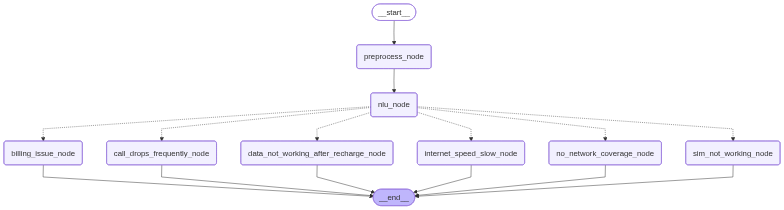

In [62]:
workflow = StateGraph(CallState)

workflow.add_node("preprocess_node", preprocess_node)
workflow.add_node("nlu_node", nlu_node)

workflow.add_node("billing_issue_node", billing_issue_node)
workflow.add_node("sim_not_working_node", sim_not_working_node)
workflow.add_node("no_network_coverage_node", no_network_coverage_node)
workflow.add_node("internet_speed_slow_node", internet_speed_slow_node)
workflow.add_node("data_not_working_after_recharge_node", data_not_working_after_recharge_node)
workflow.add_node("call_drops_frequently_node", call_drops_frequently_node)

workflow.add_edge(START, "preprocess_node")
workflow.add_edge("preprocess_node", "nlu_node")

workflow.add_conditional_edges("nlu_node", route_intent_to_node, { 
    "billing_issue_node": "billing_issue_node",
    "sim_not_working_node": "sim_not_working_node",
    "no_network_coverage_node": "no_network_coverage_node",
    "internet_speed_slow_node": "internet_speed_slow_node",
    "data_not_working_after_recharge_node": "data_not_working_after_recharge_node",
    "call_drops_frequently_node": "call_drops_frequently_node"
})

for node in ["billing_issue_node", "sim_not_working_node", "no_network_coverage_node", "internet_speed_slow_node", "data_not_working_after_recharge_node", "call_drops_frequently_node"]:
    workflow.add_edge(node, END)



workflow.compile()

In [58]:
# 2. Fix invocation - use invoke() instead of run()
initial_state = {
    "call_id": "C-2003",
    "transcript": [],
    "clean_text": "", "intent": "", "confidence": 0.0, "entities": {},
    "script": "", "next_action": "end_call"
}



In [61]:
def extract_script_text(script_obj) -> str:
    """
    Convert different possible script types into a plain string:
      - plain str
      - object with `.content` attribute (e.g. AIMessage)
      - dict with 'content' or 'text' keys
      - fallback: str(obj)
    """
    if script_obj is None:
        return ""
    # plain string
    if isinstance(script_obj, str):
        return script_obj

    # common LLM wrappers: AIMessage(content='...') or similar
    if hasattr(script_obj, "content"):
        try:
            return str(script_obj.content)
        except Exception:
            pass

    # dict-like
    if isinstance(script_obj, dict):
        for k in ("content", "text", "message"):
            if k in script_obj and isinstance(script_obj[k], str):
                return script_obj[k]

    # fallback to str()
    return str(script_obj)
result = app.invoke(initial_state)
print("Final State:", result)
content=extract_script_text(result['script'])
speak(content)

Listening (Groq Whisper)...
User Transcribed (Groq): I have issues with my cat. What should I do?
Final State: {'call_id': 'C-2003', 'transcript': [{'text': 'Willing, willing, please look into it.'}, {'text': 'you please look into it'}, {'text': 'I have issues with my cat. What should I do?'}], 'clean_text': 'i have issues with my cat. what should i do?', 'intent': 'Billing Issue', 'confidence': 0.05, 'entities': {}, 'script': AIMessage(content='I’m sorry to hear your cat isn’t feeling well—please contact a veterinarian or animal clinic right away for professional care.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 439, 'prompt_tokens': 138, 'total_tokens': 577, 'completion_time': 0.50041625, 'prompt_time': 0.011453841, 'queue_time': 0.368196576, 'total_time': 0.511870091, 'completion_tokens_details': {'reasoning_tokens': 405}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e99e93f2ac', 'finish_reason': 'stop', 'logprobs': None}, id='lc